In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.conv(x) + self.shortcut(x))

class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Block 1: 原始卷积块
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)  # 32→16
        )
        # Block 2: 残差结构替代
        self.block2 = nn.Sequential(
            ResidualBlock(64, 128),
        )
        # Block 3: 
        self.block3 = nn.Sequential(
            ResidualBlock(128, 256),
            nn.MaxPool2d(2)  # 16->8
        )
        # Block 4: 高维残差块
        self.block4 = nn.Sequential(
            ResidualBlock(256, 512),
        )

        # Block 5: 高维残差块
        self.block5 = nn.Sequential(
            ResidualBlock(512, 1024),
            nn.MaxPool2d(2)  # 8->4
        )

        self.block6 = nn.Sequential(
            ResidualBlock(1024, 1024),
            nn.MaxPool2d(2)  # 4->2
        )

        # 分类器
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = DeepCNN()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)

net.to(device)    

cuda:0
Let's use 2 GPUs!


DataParallel(
  (module): DeepCNN(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (0): ResidualBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
       

In [3]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing  # 平滑因子

    def forward(self, pred, target):
        num_classes = pred.size(1)  # 类别数
        log_probs = F.log_softmax(pred, dim=1)  # softmax + log
        # 构造 one-hot 标签
        targets = torch.zeros_like(log_probs).scatter_(1, target.unsqueeze(1), 1)
        # 标签平滑：将 one-hot 向量调整为平滑形式
        targets = (1 - self.smoothing) * targets + self.smoothing / num_classes
        # 交叉熵计算
        return -(targets * log_probs).sum(dim=1).mean()

In [4]:
import torch.optim as optim

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

train_losses = []
train_accuracies = []

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # ✅ 放入GPU
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch {epoch+1}: Loss={epoch_loss:.3f}, Accuracy={epoch_acc:.2f}%')

print('Finished Training')

PATH = './cifar_net.pth3'
torch.save(net.module.state_dict(), PATH)

net = DeepCNN()
net.load_state_dict(torch.load(PATH, weights_only=True))
net = net.to(device)                    # ✅ 必须加！把模型放GPU
net.eval()                              # ✅ 推理模式，关闭 dropout 和 batchnorm 的随机性

Epoch 1: Loss=1.784, Accuracy=39.49%
Epoch 2: Loss=1.418, Accuracy=58.50%
Epoch 3: Loss=1.244, Accuracy=67.64%
Epoch 4: Loss=1.127, Accuracy=73.48%
Epoch 5: Loss=1.032, Accuracy=78.28%
Epoch 6: Loss=0.959, Accuracy=81.74%
Epoch 7: Loss=0.885, Accuracy=85.36%
Epoch 8: Loss=0.825, Accuracy=88.31%
Epoch 9: Loss=0.767, Accuracy=91.21%
Epoch 10: Loss=0.711, Accuracy=93.69%
Epoch 11: Loss=0.667, Accuracy=95.91%
Epoch 12: Loss=0.626, Accuracy=97.69%
Epoch 13: Loss=0.594, Accuracy=98.88%
Epoch 14: Loss=0.576, Accuracy=99.51%
Epoch 15: Loss=0.562, Accuracy=99.78%
Epoch 16: Loss=0.554, Accuracy=99.90%
Epoch 17: Loss=0.548, Accuracy=99.94%
Epoch 18: Loss=0.544, Accuracy=99.97%
Epoch 19: Loss=0.542, Accuracy=99.97%
Epoch 20: Loss=0.539, Accuracy=99.99%
Finished Training


/home/hejunfeng/miniconda3/envs/hjf_env/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


DeepCNN(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))


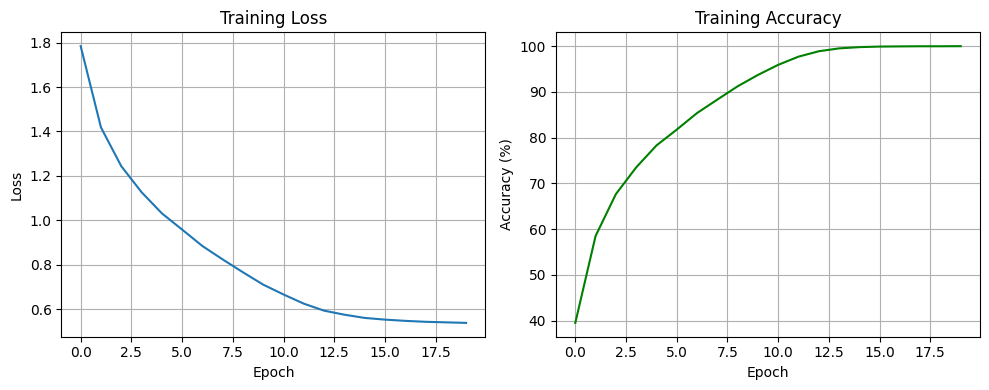

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        images, labels = images.to(device), labels.to(device)  # ✅ 放入 GPU
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 83 %
